# Estimating Gestational Diabetes Onset
### Reverse Timeseries Forecasting

## Pre-processing: Full dataset

<ul>
	<li><a href="#Imports"><strong>Imports</strong></a></li>
	<li><a href="#Notebook-Settings"><strong>Notebook Settings</a></li>
	<li><a href="#Load-the-data"><strong>Loading the data</strong></a>
		<ul>
			<li>Setting the index</li>
			<li>Reverse the timeseries</li>
		</ul>
	</li>
    <li><a href="#Visualize"><strong>Visualize</strong></a>
		<ul>
			<li>Seasonal Decompose</li>
		</ul>
	</li>
    <li><a href="#Stationarity"><strong>Stationarity</strong></a>
		<ul>
			<li>Dickey Fuller Test</li>
		</ul>
	</li>
    <li><a href="#ACF-and-PACF"><strong>ACF and PACF</strong></a></li>
    <li><a href="#Model-1:-ARIMA"><strong>Model 1: ARIMA</strong></a>
		<ul>
            <li><a href="#Finding-ARIMA-Parameters">Finding ARIMA Parameters</a></li>
		</ul>
    </li>
    <li><a href="#Model-2:-auto_arima"><strong>Model 2: auto_arima</strong></a>
		<ul>
            <li></li>
		</ul>
    </li>
</ul>


### Imports

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

from library.functions import jlcap_optimize_arima

### Notebook Settings

In [79]:
pd.set_option('display.max_rows', 500)

### Load the data

In [80]:
y = pd.read_csv('data/data_full_pre-processed.csv')
y.set_index('datetime_forward', inplace=True)

In [81]:
y.head()

,value
datetime_forward,
2021-03-11 08:01:00,105
2021-03-11 14:35:00,123
2021-03-11 18:55:00,86
2021-03-12 09:13:00,113
2021-03-12 14:33:00,111


In [82]:
y.index = pd.DatetimeIndex(y.index)
y.index

DatetimeIndex(['2021-03-11 08:01:00', '2021-03-11 14:35:00',
               '2021-03-11 18:55:00', '2021-03-12 09:13:00',
               '2021-03-12 14:33:00', '2021-03-12 19:26:00',
               '2021-03-12 21:10:00', '2021-03-13 08:56:00',
               '2021-03-13 16:30:00', '2021-03-13 20:04:00',
               ...
               '2021-05-21 15:28:00', '2021-05-21 20:09:00',
               '2021-05-21 21:49:00', '2021-05-22 10:22:00',
               '2021-05-22 15:43:00', '2021-05-22 17:21:00',
               '2021-05-22 21:45:00', '2021-05-23 11:20:00',
               '2021-05-23 20:16:00', '2021-05-23 21:56:00'],
              dtype='datetime64[ns]', name='datetime_forward', length=280, freq=None)

### Split Data into Training and Testing Sets

In [83]:
len(y)

280

In [84]:
split = int(np.floor(len(y)*.8))
split

224

In [85]:
y_train = y[:split]
y_test = y[split:]

In [86]:
y_train.shape, y_test.shape

((224, 1), (56, 1))

## Model 1: ARIMA

### Finding ARIMA Parameters

In [87]:
ps = range(0,8)
qs = range(0,8)

params = jlcap_optimize_arima(y_train, ps, qs, d=0)
params

,Order,AIC
0,"(7, 0, 5)",1795.925306
1,"(4, 0, 4)",1799.200263
2,"(5, 0, 5)",1799.707480


### Fitting a Model

In [88]:
mod = ARIMA(y_train, order=(7,0,5))
res = mod.fit()

print(res.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  224
Model:                 ARIMA(7, 0, 5)   Log Likelihood                -883.963
Date:                Wed, 09 Mar 2022   AIC                           1795.925
Time:                        21:33:02   BIC                           1843.688
Sample:                             0   HQIC                          1815.205
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.7302      2.289     47.069      0.000     103.244     112.216
ar.L1         -1.0731      0.206     -5.212      0.000      -1.477      -0.670
ar.L2         -0.4650      0.289     -1.607      0.1

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


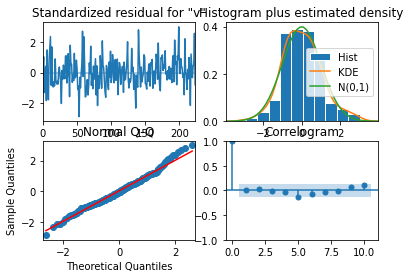

In [89]:
res.plot_diagnostics()
plt.show()

**Predictions**

2021-03-11 08:01:00 2021-05-23 21:56:00


KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

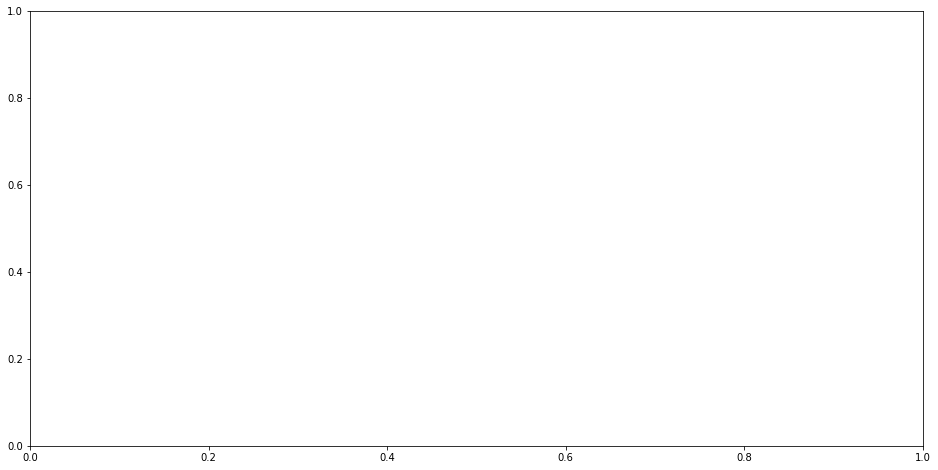

In [92]:
fig, ax = plt.subplots(figsize=(16, 8))

start_datetime = y_train.iloc[0].name
end_datetime = y_test.iloc[-1].name
print(start_datetime, end_datetime)

fig = plot_predict(res, start="2021-03-11 08:01:00", end="2021-05-23 21:56:00", ax=ax)
ax.plot(y, label='Actual')
legend = ax.legend(loc="upper left")

In [93]:
predictions = res.forecast(steps=len(y_test))
predictions.rename('value', inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: DeprecationWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


224    110.652591
225    113.841167
226    123.087420
227     98.821103
228    117.017355
229    109.682829
230    118.502680
231    106.183487
232    107.772821
233    119.523968
234    109.493152
235    106.728711
236    114.885112
237    109.896542
238    113.817281
239    106.989688
240    110.461669
241    116.306762
242    105.898281
243    110.749039
244    112.725400
245    108.833562
246    112.399876
247    107.200841
248    111.849910
249    112.542641
250    105.906221
251    112.504830
252    110.150574
253    108.850793
254    111.490613
255    107.363980
256    112.068531
257    109.794978
258    107.170762
259    112.462909
260    108.227999
261    109.516730
262    110.418076
263    107.638865
264    111.650463
265    108.162179
266    108.520956
267    111.387737
268    107.343366
269    110.130489
270    109.249757
271    108.084444
272    110.897768
273    107.409438
274    109.455655
275    110.000855
276    107.317788
277    110.307350
278    108.261778
279    108

In [94]:
y_pred = pd.DataFrame(predictions)
y_pred.tail()

,value
275,110.000855
276,107.317788
277,110.307350
278,108.261778
279,108.605010


<AxesSubplot:xlabel='datetime_forward'>

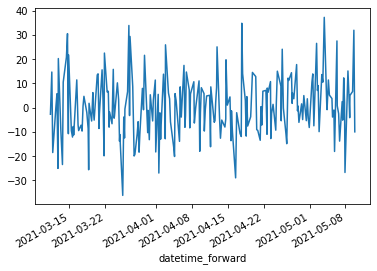

In [95]:
res.resid.plot()

In [96]:
rmse_arima = mean_squared_error(y_test, y_pred, squared=False)

print("Arima RMSE: %.3f" % rmse_arima)

Arima RMSE: 13.527


In [97]:
res_conf_int = res.conf_int()
res_conf_int

,0,1
const,103.244341,112.216128
ar.L1,-1.476608,-0.669525
ar.L2,-1.032330,0.102310
ar.L3,0.159991,0.973049
ar.L4,0.603948,1.252275
ar.L5,0.557988,1.193562
ar.L6,-0.126632,0.489540
ar.L7,-0.425528,-0.005759
ma.L1,0.584691,1.319923
ma.L2,-0.083769,0.925805


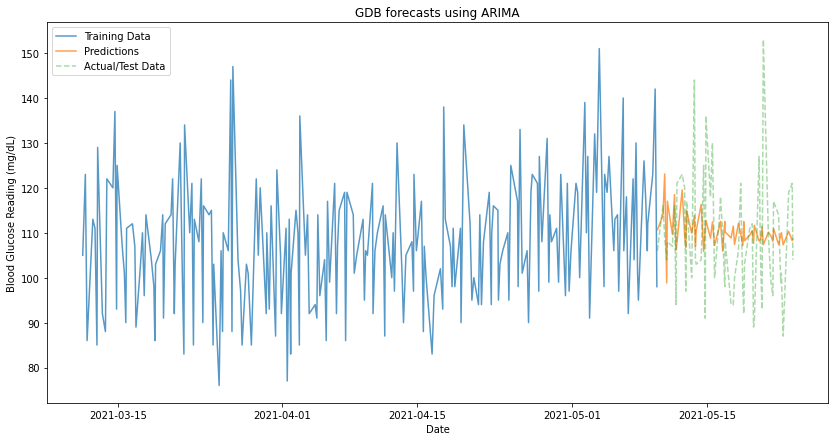

In [99]:
# Plot the points and the forecasts
training_days = pd.Series(y_train.index)
testing_days = pd.Series(y_test.index)

plt.figure(figsize=(14,7))

plt.plot(training_days, y_train, alpha=0.75, label='Training Data')
plt.plot(testing_days, y_pred, alpha=0.75, label='Predictions')  # Forecasts
plt.plot(testing_days, y_test,
            alpha=0.4, linestyle='--', label='Actual/Test Data')  # Test data
# plt.fill_between(testing_days, res_conf_int[:, 0], res_conf_int[:, 1], alpha=0.1, color='b')

plt.title("GDB forecasts using ARIMA")
plt.xlabel("Date")
plt.ylabel("Blood Glucose Reading (mg/dL)")
plt.legend(loc='upper left')

plt.savefig('vis/arima_full_pred_vs_test.png', bbox_inches="tight")
plt.show()

## Model 2: auto_arima

In [100]:
# Fit a simple auto_arima model
mod_auto = auto_arima(y_train, start_p=0, start_q=0,
                     max_p=10, max_q=10, d=0,
                     stepwise=True, suppress_warnings=True,
                     error_action='ignore')

mod_auto.order

(1, 0, 1)

In [101]:
mod_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  224
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -900.197
Date:                Wed, 09 Mar 2022   AIC                           1808.393
Time:                        21:43:35   BIC                           1822.040
Sample:                             0   HQIC                          1813.902
                                - 224                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    207.9564      4.874     42.663      0.000     198.403     217.510
ar.L1         -0.9331      0.043    -21.505      0.000      -1.018      -0.848
ma.L1          0.8063      0.075     10.719      0.000       0.659       0.954
sigma2       180.9520     18.370      9.850      0.000     144.947     216.957
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.23
Prob(Q):                              0.85   Prob(JB):                         0.20
Heteroskedasticity (H):               0.94   Skew:                             0.28
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
# Create predictions for the future, evaluate on test
preds, conf_int = mod_auto.predict(n_periods=y_test.shape[0], return_conf_int=True)

rmse_auto_arima = mean_squared_error(y_test, preds, squared=False)
print("Auto Arima RMSE: %.3f" % rmse_auto_arima)

Auto Arima RMSE: 13.358


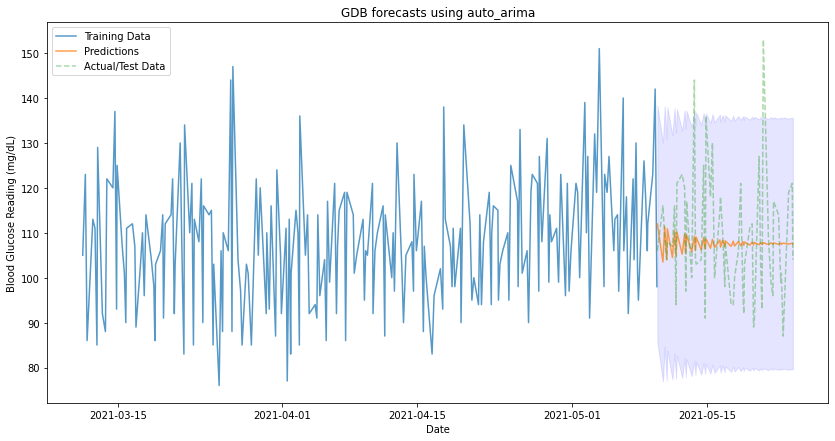

In [103]:
# Plot the points and the forecasts
training_days = pd.Series(y_train.index)
testing_days = pd.Series(y_test.index)

plt.figure(figsize=(14,7))

plt.plot(training_days, y_train, alpha=0.75, label='Training Data')
plt.plot(testing_days, preds, alpha=0.75, label='Predictions')  # Forecasts
plt.plot(testing_days, y_test,
            alpha=0.4, linestyle='--', label='Actual/Test Data')  # Test data
plt.fill_between(testing_days,
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')

plt.title("GDB forecasts using auto_arima")
plt.xlabel("Date")
plt.ylabel("Blood Glucose Reading (mg/dL)")
plt.legend(loc='upper left')

plt.savefig('vis/auto_arima_full_pred_vs_test.png', bbox_inches="tight")
plt.show()

### Model Comparisons

In [104]:
std_test = np.std(y_test.values)
std_test

13.57968498853177

In [107]:
model_scores = pd.DataFrame({
	'RMSE': [rmse_arima, rmse_auto_arima], 
    'Standardized': [rmse_arima/std_test, rmse_auto_arima/std_test]},
	index=['ARIMA (7, 0, 5)', 'Auto Arima'])
model_scores

,RMSE,Standardized
"ARIMA (7, 0, 5)",13.526907,0.996113
Auto Arima,13.358158,0.983687


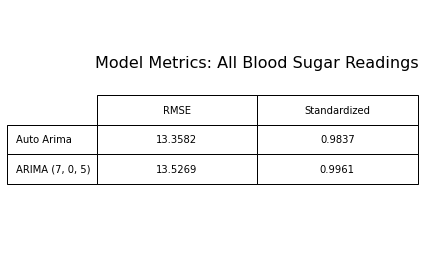

In [109]:
model_scores.sort_values(by='Standardized', inplace=True)

fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')

table = ax.table(
    cellText=np.round(model_scores.values,4), 
    colLabels=model_scores.columns, 
    rowLabels=model_scores.index, 
    loc='center', 
    cellLoc='center'
)

table.scale(1, 2)
plt.title('Model Metrics: All Blood Sugar Readings', size=16, y=.75)
plt.tight_layout(h_pad=2)

plt.show()

fig.savefig('vis/all_bg_model_metrics.png', bbox_inches="tight")
